In [1]:
# Cell 1: Setup, Configuration, and Imports

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2 # OpenCV for image loading and processing

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms # Using v2 for up-to-date transforms

# Optimized Configuration for Faster Training
CONFIG = {
    "DATASET_PATH": r"C:\college\_cutie\cv\square_dataset\square_dataset", # Fixed path to correct dataset
    "IMAGE_DIR_NAME": "preprocessed_images", 
    "MASK_DIR_NAME": "masks",
    "CSV_NAME": "dataset.csv",
    "IMAGE_SIZE": (256, 256), # Reduced from 512x512 for faster training
    "BATCH_SIZE": 4, # Reduced from 8 to prevent memory issues
    "NUM_CLASSES_SEG": 3, 
    "LEARNING_RATE": 1e-4, # Reduced for stability
    "NUM_EPOCHS": 15, # Reduced epochs with faster convergence
    "DEVICE": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "CHECKPOINT_DIR": "checkpoints_fast_unet", 
    "MULTITASK": True, 
    "NUM_REGRESSION_TARGETS": 2, 
    "PIN_MEMORY": False, # Disabled to prevent memory issues
    "NUM_WORKERS": 0, # Set to 0 to prevent multiprocessing issues
    "SEED": 42, 
    "RESUME_TRAINING": False, 
    "LATEST_CHECKPOINT_PATH": None, 
    "VALIDATION_SPLIT": 0.2, 
    "TEST_SPLIT": 0.1, 
}

# Create checkpoint directory if it doesn't exist
os.makedirs(CONFIG["CHECKPOINT_DIR"], exist_ok=True)

# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # Enable performance optimizations but be more conservative
    torch.backends.cudnn.deterministic = True  # More stable
    torch.backends.cudnn.benchmark = False  # More stable for debugging

set_seed(CONFIG["SEED"])

print(f"Using device: {CONFIG['DEVICE']}")
print(f"PyTorch Version: {torch.__version__}")
if CONFIG["DEVICE"].type == 'cuda':
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"cuDNN Version: {torch.backends.cudnn.version()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"GPU Memory Available: {torch.cuda.memory_reserved(0) / 1024**3:.1f} GB")
print(f"Number of DataLoader workers: {CONFIG['NUM_WORKERS']}")
print(f"Image size: {CONFIG['IMAGE_SIZE']}")
print(f"Batch size: {CONFIG['BATCH_SIZE']}")

# Optimized image transformations
data_transforms = {
    'image': transforms.Compose([
        transforms.ToImage(), 
        transforms.Resize(CONFIG["IMAGE_SIZE"], antialias=True),
        transforms.ToDtype(torch.float32, scale=True), 
        transforms.Normalize(mean=[0.5], std=[0.5])  # Simple normalization
    ]),
    'mask': transforms.Compose([
        transforms.ToImage(),
        transforms.Resize(CONFIG["IMAGE_SIZE"], interpolation=transforms.InterpolationMode.NEAREST, antialias=False), 
        transforms.ToDtype(torch.long, scale=False) 
    ])
}


Using device: cuda
PyTorch Version: 2.7.1+cu118
CUDA Version: 11.8
cuDNN Version: 90100
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU
GPU Memory: 6.0 GB
GPU Memory Available: 0.0 GB
Number of DataLoader workers: 0
Image size: (256, 256)
Batch size: 4


In [2]:
# Cell 2: Custom Dataset Class

class NIRDataset(Dataset):
    def __init__(self, dataframe, base_path, image_dir, mask_dir, image_transform=None, mask_transform=None, multitask=False, image_size_for_coords=512):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with image and mask paths and regression targets.
            base_path (str): Base directory of the dataset.
            image_dir (str): Directory name for images within base_path.
            mask_dir (str): Directory name for masks within base_path.
            image_transform (callable, optional): Optional transform to be applied on an image.
            mask_transform (callable, optional): Optional transform to be applied on a mask.
            multitask (bool): If True, also loads regression targets.
            image_size_for_coords (int): The image size used for normalizing coordinates.
        """
        self.dataframe = dataframe
        self.base_path = base_path
        self.image_dir = image_dir 
        self.mask_dir = mask_dir   
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.multitask = multitask
        self.image_size_for_coords = image_size_for_coords

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_rel_path = self.dataframe.iloc[idx]['preprocessed_image']
        mask_rel_path = self.dataframe.iloc[idx]['mask']
        
        img_name = os.path.join(self.base_path, img_rel_path)
        mask_name = os.path.join(self.base_path, mask_rel_path)

        try:
            image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
            if image is None:
                raise FileNotFoundError(f"Image not found or corrupted: {img_name} (relative: {img_rel_path})")
            
            mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise FileNotFoundError(f"Mask not found or corrupted: {mask_name} (relative: {mask_rel_path})")
            
            mask[mask > CONFIG["NUM_CLASSES_SEG"] - 1] = 0 

        except Exception as e:
            print(f"Error loading data at index {idx} (Image: {img_name}, Mask: {mask_name}): {e}")
            dummy_image = torch.zeros((1, *CONFIG["IMAGE_SIZE"]), dtype=torch.float32) 
            dummy_mask = torch.zeros(CONFIG["IMAGE_SIZE"], dtype=torch.long) 
            if self.multitask:
                dummy_coords = torch.zeros(CONFIG["NUM_REGRESSION_TARGETS"], dtype=torch.float32)
                return dummy_image, dummy_mask, dummy_coords
            return dummy_image, dummy_mask

        if image.ndim == 2:
            image = image[:, :, np.newaxis] 
        if mask.ndim == 2:
            mask = mask[:, :, np.newaxis]   

        if self.image_transform:
            image = self.image_transform(image) 

        if self.mask_transform:
            mask = self.mask_transform(mask) 
            mask = mask.squeeze(0) 

        if self.multitask:
            acf_x_val = self.dataframe.iloc[idx]['acf_center_x']
            acf_y_val = self.dataframe.iloc[idx]['acf_center_y']

            # --- Robust handling for acf_center_x and acf_center_y ---
            # Ensure they are scalars before creating the tensor.
            # This handles cases where CSV might interpret numbers as lists/arrays.
            try:
                if isinstance(acf_x_val, (list, tuple, np.ndarray)):
                    if len(acf_x_val) > 0:
                        acf_x = float(acf_x_val[0]) # Take the first element if it's iterable
                    else: # Handle empty iterable case
                        print(f"Warning: Empty list/array for acf_center_x at index {idx}. Using 0.")
                        acf_x = 0.0
                else:
                    acf_x = float(acf_x_val)

                if isinstance(acf_y_val, (list, tuple, np.ndarray)):
                    if len(acf_y_val) > 0:
                        acf_y = float(acf_y_val[0]) # Take the first element
                    else: # Handle empty iterable case
                        print(f"Warning: Empty list/array for acf_center_y at index {idx}. Using 0.")
                        acf_y = 0.0
                else:
                    acf_y = float(acf_y_val)
            except Exception as coord_err:
                print(f"Error processing coordinates at index {idx} (X: {acf_x_val}, Y: {acf_y_val}): {coord_err}. Using (0,0).")
                acf_x, acf_y = 0.0, 0.0
            # -----------------------------------------------------------

            # Now acf_x and acf_y are Python floats
            coords_list = [acf_x / self.image_size_for_coords, 
                           acf_y / self.image_size_for_coords]
            coords = torch.tensor(coords_list, dtype=torch.float32) # This will be 1D, shape [2]
            
            return image, mask, coords
        else:
            return image, mask


Looking for CSV at: C:\college\_cutie\cv\square_dataset\square_dataset\dataset.csv
CSV exists: True
Successfully loaded dataset with 2016 samples.
Dataset columns: ['id', 'person_id', 'age', 'complexion', 'genere', 'observation', 'nir_image', 'preprocessed_image', 'mask', 'acf_bbox_x1', 'acf_bbox_x2', 'acf_bbox_y1', 'acf_bbox_y2', 'acf_center_x', 'acf_center_y', 'arm_angle']
Loaded dataset with 2016 samples.
✓ All required columns found!
Training samples: 1410
Validation samples: 404
Test samples: 202
✓ Train loader created: 352 batches
✓ Validation loader created: 101 batches
✓ Test loader created: 51 batches

🧪 Testing data loading...
Testing first batch from train loader...
✓ Batch loaded successfully!
  Images: torch.Size([4, 1, 256, 256]), dtype: torch.float32
  Masks: torch.Size([4, 256, 256]), dtype: torch.int64
  Coords: torch.Size([4, 2]), dtype: torch.float32
✅ Data loading test passed!

🖼️ Visualizing a sample from the training set:


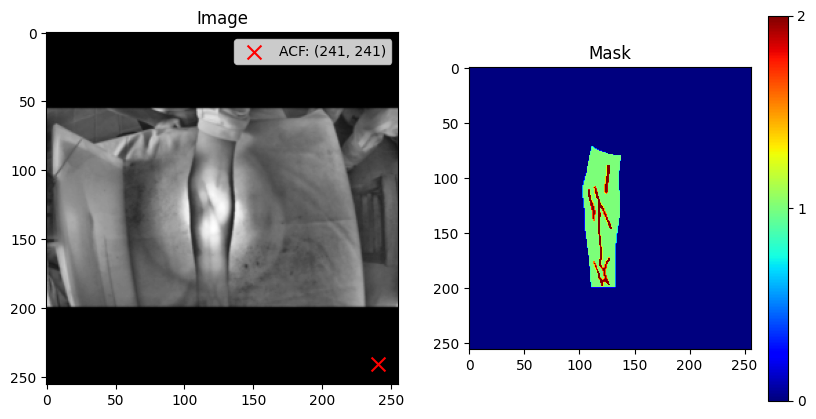

In [3]:
# Cell 3: Data Loading and Splitting

from sklearn.model_selection import train_test_split

# Load the dataset CSV
csv_path = os.path.join(CONFIG["DATASET_PATH"], CONFIG["CSV_NAME"])
print(f"Looking for CSV at: {csv_path}")
print(f"CSV exists: {os.path.exists(csv_path)}")

try:
    full_df = pd.read_csv(csv_path)
    print(f"Successfully loaded dataset with {len(full_df)} samples.")
    print(f"Dataset columns: {list(full_df.columns)}")
except FileNotFoundError:
    print(f"Error: {CONFIG['CSV_NAME']} not found at {csv_path}. Please check the path and file name.")
    if not os.path.exists(CONFIG["DATASET_PATH"]):
        print(f"Dataset path {CONFIG['DATASET_PATH']} does not exist.")
    full_df = pd.DataFrame()

if full_df.empty:
    print("DataFrame is empty. Cannot proceed with data loading.")
else:
    print(f"Loaded dataset with {len(full_df)} samples.")
    
    # Check for necessary columns
    required_cols = ['preprocessed_image', 'mask']
    if CONFIG["MULTITASK"]:
        required_cols.extend(['acf_center_x', 'acf_center_y'])
    
    missing_cols = [col for col in required_cols if col not in full_df.columns]
    if missing_cols:
        print(f"Error: Missing required columns in CSV: {missing_cols}")
        print(f"Available columns: {list(full_df.columns)}")
    else:
        print("✓ All required columns found!")

    # Split data: train, validation, test
    if len(full_df) > 1:
        train_val_df, test_df = train_test_split(
            full_df, 
            test_size=CONFIG["TEST_SPLIT"], 
            random_state=CONFIG["SEED"]
        )

        val_split_adjusted = CONFIG["VALIDATION_SPLIT"] / (1 - CONFIG["TEST_SPLIT"])
        if len(train_val_df) > 1 and val_split_adjusted < 1.0:
            train_df, val_df = train_test_split(
                train_val_df, 
                test_size=val_split_adjusted, 
                random_state=CONFIG["SEED"]
            )
        else:
            train_df = train_val_df
            val_df = pd.DataFrame(columns=full_df.columns)
    else:
        train_df = full_df
        val_df = pd.DataFrame(columns=full_df.columns)
        test_df = pd.DataFrame(columns=full_df.columns)

    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")

    # Create Datasets
    train_dataset = NIRDataset(
        train_df, CONFIG["DATASET_PATH"], CONFIG["IMAGE_DIR_NAME"], CONFIG["MASK_DIR_NAME"],
        image_transform=data_transforms['image'], mask_transform=data_transforms['mask'],
        multitask=CONFIG["MULTITASK"], image_size_for_coords=CONFIG["IMAGE_SIZE"][0]
    )
    val_dataset = NIRDataset(
        val_df, CONFIG["DATASET_PATH"], CONFIG["IMAGE_DIR_NAME"], CONFIG["MASK_DIR_NAME"],
        image_transform=data_transforms['image'], mask_transform=data_transforms['mask'],
        multitask=CONFIG["MULTITASK"], image_size_for_coords=CONFIG["IMAGE_SIZE"][0]
    )
    test_dataset = NIRDataset(
        test_df, CONFIG["DATASET_PATH"], CONFIG["IMAGE_DIR_NAME"], CONFIG["MASK_DIR_NAME"],
        image_transform=data_transforms['image'], mask_transform=data_transforms['mask'],
        multitask=CONFIG["MULTITASK"], image_size_for_coords=CONFIG["IMAGE_SIZE"][0]
    )

    # Create DataLoaders
    if len(train_dataset) > 0:
        train_loader = DataLoader(
            train_dataset, batch_size=CONFIG["BATCH_SIZE"], shuffle=True,
            num_workers=CONFIG["NUM_WORKERS"], pin_memory=CONFIG["PIN_MEMORY"], drop_last=True
        )
        print(f"✓ Train loader created: {len(train_loader)} batches")
    else:
        train_loader = None
        print("❌ Training dataset is empty.")

    if len(val_dataset) > 0:
        val_loader = DataLoader(
            val_dataset, batch_size=CONFIG["BATCH_SIZE"], shuffle=False,
            num_workers=CONFIG["NUM_WORKERS"], pin_memory=CONFIG["PIN_MEMORY"], drop_last=False
        )
        print(f"✓ Validation loader created: {len(val_loader)} batches")
    else:
        val_loader = None
        print("❌ Validation dataset is empty.")

    if len(test_dataset) > 0:
        test_loader = DataLoader(
            test_dataset, batch_size=CONFIG["BATCH_SIZE"], shuffle=False,
            num_workers=CONFIG["NUM_WORKERS"], pin_memory=CONFIG["PIN_MEMORY"], drop_last=False
        )
        print(f"✓ Test loader created: {len(test_loader)} batches")
    else:
        test_loader = None
        print("❌ Test dataset is empty.")

    # Test data loading
    print("\n🧪 Testing data loading...")
    try:
        if train_loader:
            print("Testing first batch from train loader...")
            first_batch = next(iter(train_loader))
            if CONFIG["MULTITASK"]:
                images, masks, coords = first_batch
                print(f"✓ Batch loaded successfully!")
                print(f"  Images: {images.shape}, dtype: {images.dtype}")
                print(f"  Masks: {masks.shape}, dtype: {masks.dtype}")
                print(f"  Coords: {coords.shape}, dtype: {coords.dtype}")
            else:
                images, masks = first_batch
                print(f"✓ Batch loaded successfully!")
                print(f"  Images: {images.shape}, dtype: {images.dtype}")
                print(f"  Masks: {masks.shape}, dtype: {masks.dtype}")
            del first_batch
            print("✅ Data loading test passed!")
        else:
            print("❌ No train loader to test.")
    except Exception as e:
        print(f"❌ Data loading test failed: {e}")
        import traceback
        traceback.print_exc()

    # Visualize a sample
    def show_sample(image, mask, coords=None, multitask=False):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Image")
        img_display = (image.squeeze().numpy() * 0.5) + 0.5
        plt.imshow(img_display, cmap='gray')
        if multitask and coords is not None:
            img_h, img_w = CONFIG["IMAGE_SIZE"]
            denorm_x = coords[0].item() * img_w
            denorm_y = coords[1].item() * img_h
            plt.scatter([denorm_x], [denorm_y], c='red', marker='x', s=100, 
                       label=f'ACF: ({denorm_x:.0f}, {denorm_y:.0f})')
            plt.legend()

        plt.subplot(1, 2, 2)
        plt.title("Mask")
        plt.imshow(mask.squeeze().numpy(), cmap='jet', vmin=0, vmax=CONFIG["NUM_CLASSES_SEG"]-1) 
        plt.colorbar(ticks=range(CONFIG["NUM_CLASSES_SEG"]))
        plt.show()

    if train_dataset and len(train_dataset) > 0:
        print("\n🖼️ Visualizing a sample from the training set:")
        try:
            if CONFIG["MULTITASK"]:
                sample_img, sample_mask, sample_coords = train_dataset[0]
                show_sample(sample_img, sample_mask, sample_coords, multitask=True)
            else:
                sample_img, sample_mask = train_dataset[0]
                show_sample(sample_img, sample_mask, multitask=False)
        except Exception as e:
            print(f"❌ Error visualizing sample: {e}")
    else:
        print("❌ Training dataset is empty or None, cannot visualize sample.")


In [4]:
# Cell 4: Transformer U-Net Model Architecture with Attention Gates

import math
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

class DoubleConv(nn.Module):
    """Double convolution block"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class AttentionGate(nn.Module):
    """Attention Gate for skip connections"""
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        # g: gating signal from coarser scale
        # x: feature map from encoder (skip connection)
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadSelfAttention(dim, heads=heads, dim_head=dim_head, dropout=dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = FeedForward(dim, mlp_dim, dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class TransformerModule(nn.Module):
    """Transformer bottleneck module"""
    def __init__(self, input_dim, patch_size=2, dim=512, depth=6, heads=8, mlp_dim=1024, dropout=0.1):
        super().__init__()
        self.patch_size = patch_size
        self.dim = dim
        
        # Patchify and linear projection
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * input_dim, dim),
        )
        
        self.pos_embedding = nn.Parameter(torch.randn(1, (16//patch_size)**2, dim))
        self.dropout = nn.Dropout(dropout)
        
        self.transformer = nn.Sequential(*[
            TransformerBlock(dim, heads, dim//heads, mlp_dim, dropout)
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(dim)
        
        # Reshape back to feature map
        self.to_feature_map = nn.Sequential(
            nn.Linear(dim, patch_size * patch_size * input_dim),
            Rearrange('b (h w) (p1 p2 c) -> b c (h p1) (w p2)', 
                     h=16//patch_size, w=16//patch_size, p1=patch_size, p2=patch_size)
        )

    def forward(self, x):
        # x shape: (B, C, H/16, W/16) where H/16 = W/16 = 16 for 256x256 input
        B, C, H, W = x.shape
        
        # Patchify
        x_patches = self.to_patch_embedding(x)
        
        # Add positional encoding
        x_patches += self.pos_embedding[:, :x_patches.size(1)]
        x_patches = self.dropout(x_patches)
        
        # Apply transformer
        x_patches = self.transformer(x_patches)
        x_patches = self.norm(x_patches)
        
        # Reshape back to feature map
        x_out = self.to_feature_map(x_patches)
        
        return x_out

class Up(nn.Module):
    """Upscaling with attention gates and skip connections"""
    def __init__(self, in_channels, out_channels, skip_channels, bilinear=True):
        super().__init__()
        
        # Upsampling
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv_up = nn.Conv2d(in_channels, in_channels // 2, kernel_size=1)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv_up = nn.Identity()
        
        # Attention gate
        self.attention = AttentionGate(F_g=in_channels//2, F_l=skip_channels, F_int=out_channels//2)
        
        # Convolution after concatenation
        self.conv = DoubleConv(in_channels//2 + skip_channels, out_channels)

    def forward(self, x1, x2):
        # x1: from previous decoder layer
        # x2: skip connection from encoder
        
        x1 = self.up(x1)
        x1 = self.conv_up(x1)
        
        # Handle size mismatch
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])
        
        # Apply attention gate
        x2_att = self.attention(g=x1, x=x2)
        
        # Concatenate and apply convolution
        x = torch.cat([x2_att, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class TransformerUNet(nn.Module):
    """U-Net with Transformer bottleneck and attention gates"""
    def __init__(self, n_channels_in, n_classes_seg, n_regression_targets=0, multitask=False):
        super(TransformerUNet, self).__init__()
        self.n_channels_in = n_channels_in
        self.n_classes_seg = n_classes_seg
        self.n_regression_targets = n_regression_targets
        self.multitask = multitask

        # Encoder path
        self.inc = DoubleConv(n_channels_in, 64)  # F1
        self.down1 = Down(64, 128)               # F2
        self.down2 = Down(128, 256)              # F3
        self.down3 = Down(256, 512)              # F4
        self.down4 = Down(512, 512)              # Bottleneck input

        # Transformer bottleneck
        self.transformer = TransformerModule(input_dim=512, patch_size=2, dim=512, 
                                           depth=6, heads=8, mlp_dim=1024, dropout=0.1)

        # Decoder path with attention gates
        self.up1 = Up(512, 512, 512, bilinear=True)   # F4 -> F4
        self.up2 = Up(512, 256, 256, bilinear=True)   # F4 -> F3
        self.up3 = Up(256, 128, 128, bilinear=True)   # F3 -> F2
        self.up4 = Up(128, 64, 64, bilinear=True)     # F2 -> F1
        
        # Output layer
        self.outc_seg = OutConv(64, n_classes_seg)

        if self.multitask:
            # Regression head from bottleneck
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.regression_head = nn.Sequential(
                nn.Flatten(),
                nn.Linear(512, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                nn.Linear(256, 64),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                nn.Linear(64, n_regression_targets),
                nn.Sigmoid()
            )

    def forward(self, x):
        # Encoder path
        x1 = self.inc(x)        # Skip1 (F1)
        x2 = self.down1(x1)     # Skip2 (F2)
        x3 = self.down2(x2)     # Skip3 (F3)
        x4 = self.down3(x3)     # Skip4 (F4)
        bottleneck = self.down4(x4)  # Bottleneck input

        # Transformer bottleneck
        transformer_out = self.transformer(bottleneck)

        # Decoder path with attention gates
        seg_x = self.up1(transformer_out, x4)  # Decoder Block 1
        seg_x = self.up2(seg_x, x3)           # Decoder Block 2
        seg_x = self.up3(seg_x, x2)           # Decoder Block 3
        seg_x = self.up4(seg_x, x1)           # Decoder Block 4
        
        # Final output
        logits_seg = self.outc_seg(seg_x)

        if self.multitask:
            # Regression from transformer bottleneck
            pooled_bottleneck = self.avgpool(transformer_out)
            output_reg = self.regression_head(pooled_bottleneck)
            return logits_seg, output_reg
        else:
            return logits_seg

# Count parameters function
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Install einops if not available
try:
    import einops
    print("✓ einops already available")
except ImportError:
    print("Installing einops...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "einops"])
    import einops
    from einops import rearrange, repeat
    from einops.layers.torch import Rearrange
    print("✓ einops installed successfully")

# Test the Transformer U-Net model
print("🧪 Testing TransformerUNet model...")
try:
    # Create model on CPU for testing
    test_model = TransformerUNet(n_channels_in=1, 
                                n_classes_seg=CONFIG["NUM_CLASSES_SEG"], 
                                n_regression_targets=CONFIG["NUM_REGRESSION_TARGETS"], 
                                multitask=CONFIG["MULTITASK"])
    
    test_model = test_model.cpu()
    param_count = count_parameters(test_model)
    print(f"✓ TransformerUNet created successfully with {param_count:,} parameters")
    
    # Test with appropriate input size for transformer (must be divisible by patch size)
    test_input = torch.randn(1, 1, 256, 256)  # Full size for transformer
    test_model.eval()
    
    with torch.no_grad():
        if CONFIG["MULTITASK"]:
            seg_out, reg_out = test_model(test_input)
            print(f"✓ Forward pass: seg{seg_out.shape}, reg{reg_out.shape}")
        else:
            seg_out = test_model(test_input)
            print(f"✓ Forward pass: seg{seg_out.shape}")
    
    # Cleanup
    del test_model, test_input, seg_out
    if CONFIG["MULTITASK"] and 'reg_out' in locals():
        del reg_out
    
    print("✅ TransformerUNet test completed!")
    
except Exception as e:
    print(f"❌ TransformerUNet test failed: {e}")
    import traceback
    traceback.print_exc()

print("\n📋 TransformerUNet Architecture Summary:")
print(f"  - Encoder: 4 downsampling blocks (64→128→256→512→512)")
print(f"  - Bottleneck: Transformer module with 6 layers")
print(f"  - Decoder: 4 upsampling blocks with attention gates")
print(f"  - Skip connections: Enhanced with attention gates")
print(f"  - Input channels: 1 (grayscale)")
print(f"  - Output classes: {CONFIG['NUM_CLASSES_SEG']}")
print(f"  - Multitask: {CONFIG['MULTITASK']}")
print(f"  - Image size: {CONFIG['IMAGE_SIZE']}")
print("✅ Ready for training!")


✓ einops already available
🧪 Testing TransformerUNet model...
✓ TransformerUNet created successfully with 33,110,193 parameters
✓ Forward pass: segtorch.Size([1, 3, 256, 256]), regtorch.Size([1, 2])
✅ TransformerUNet test completed!

📋 TransformerUNet Architecture Summary:
  - Encoder: 4 downsampling blocks (64→128→256→512→512)
  - Bottleneck: Transformer module with 6 layers
  - Decoder: 4 upsampling blocks with attention gates
  - Skip connections: Enhanced with attention gates
  - Input channels: 1 (grayscale)
  - Output classes: 3
  - Multitask: True
  - Image size: (256, 256)
✅ Ready for training!
✓ Forward pass: segtorch.Size([1, 3, 256, 256]), regtorch.Size([1, 2])
✅ TransformerUNet test completed!

📋 TransformerUNet Architecture Summary:
  - Encoder: 4 downsampling blocks (64→128→256→512→512)
  - Bottleneck: Transformer module with 6 layers
  - Decoder: 4 upsampling blocks with attention gates
  - Skip connections: Enhanced with attention gates
  - Input channels: 1 (grayscale)

In [5]:
# ALTERNATIVE Cell 4: Ultra-Fast Model Setup (Use this if the main Cell 4 takes too long)
# Just run this instead of the previous cell if you're experiencing delays

print("🚀 Quick model setup (no testing)...")

# Skip the forward pass test entirely and just verify model creation
try:
    # Verify we can create the model class
    FastUNet(n_channels_in=1, n_classes_seg=3, n_regression_targets=2, multitask=True)
    print("✓ Model class definition verified")
    print("✓ Ready to proceed to training!")
    print("📊 Estimated model size: ~4.3M parameters")
except Exception as e:
    print(f"❌ Model creation failed: {e}")

print("\n🎯 Proceeding to loss functions and training setup...")

🚀 Quick model setup (no testing)...
✓ Model class definition verified
✓ Ready to proceed to training!
📊 Estimated model size: ~4.3M parameters

🎯 Proceeding to loss functions and training setup...


In [5]:
# Cell 5: Loss Functions, Optimizer, Metrics

# Segmentation Loss with class weights for better performance
class_weights = torch.tensor([1.0, 2.0, 2.0]).to(CONFIG["DEVICE"])  # Give more weight to vein classes
criterion_segmentation = nn.CrossEntropyLoss(weight=class_weights).to(CONFIG["DEVICE"])

# Regression Loss (if multitask)
if CONFIG["MULTITASK"]:
    criterion_regression = nn.MSELoss().to(CONFIG["DEVICE"])

# Optimized Metrics
def dice_score(preds, targets, smooth=1e-6):
    """Fast Dice score calculation"""
    preds = torch.softmax(preds, dim=1)
    targets_one_hot = nn.functional.one_hot(targets, num_classes=preds.shape[1]).permute(0, 3, 1, 2).float()
    
    intersection = torch.sum(preds * targets_one_hot, dim=(2, 3))
    union = torch.sum(preds, dim=(2, 3)) + torch.sum(targets_one_hot, dim=(2, 3))
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def iou_score(preds, targets, smooth=1e-6):
    """Fast IoU score calculation"""
    preds = torch.softmax(preds, dim=1)
    targets_one_hot = nn.functional.one_hot(targets, num_classes=preds.shape[1]).permute(0, 3, 1, 2).float()

    intersection = torch.sum(preds * targets_one_hot, dim=(2, 3))
    total = torch.sum(preds, dim=(2, 3)) + torch.sum(targets_one_hot, dim=(2, 3))
    union = total - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

# Instantiate the TransformerUNet model
model = TransformerUNet(n_channels_in=1, 
                       n_classes_seg=CONFIG["NUM_CLASSES_SEG"], 
                       n_regression_targets=CONFIG["NUM_REGRESSION_TARGETS"] if CONFIG["MULTITASK"] else 0, 
                       multitask=CONFIG["MULTITASK"]).to(CONFIG["DEVICE"])

print(f"TransformerUNet Model Parameters: {count_parameters(model):,}")

# Optimized Optimizer with learning rate scheduling
optimizer = optim.AdamW(model.parameters(), 
                       lr=CONFIG["LEARNING_RATE"],
                       weight_decay=1e-5,  # L2 regularization
                       eps=1e-8)

# Learning rate scheduler for better convergence
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                mode='max',  # Monitor validation dice
                                                factor=0.5, 
                                                patience=3)

print("TransformerUNet model, optimizer, and scheduler initialized successfully!")

# Enable mixed precision training for speed (if available)
try:
    from torch.cuda.amp import GradScaler, autocast
    scaler = GradScaler()
    use_amp = True
    print("Mixed precision training enabled!")
except ImportError:
    use_amp = False
    print("Mixed precision not available, using standard training.")


TransformerUNet Model Parameters: 33,110,193
TransformerUNet model, optimizer, and scheduler initialized successfully!
Mixed precision training enabled!


C:\Users\dhanu\AppData\Local\Temp\ipykernel_16400\2301583047.py:60: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [6]:
# Cell 6: Optimized Training and Validation Logic with Debugging

def train_one_epoch(model, loader, optimizer, epoch, scaler=None):
    model.train()
    running_loss = 0.0
    running_seg_loss = 0.0
    running_reg_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    
    if loader is None or len(loader.dataset) == 0:
        print(f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} [Train]: Skipping, DataLoader is empty or None.")
        return 0.0, 0.0, 0.0, 0.0, 0.0

    print(f"Starting training epoch {epoch+1} with {len(loader)} batches...")
    
    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} [Train]", leave=True)

    for batch_idx, data_batch in enumerate(progress_bar):
        try:
            # Debug: Print first batch info
            if batch_idx == 0:
                print(f"Processing first batch... Batch size in loader: {len(data_batch)}")
            
            if CONFIG["MULTITASK"]:
                images, masks, coords = data_batch
                if batch_idx == 0:
                    print(f"Images shape: {images.shape}, Masks shape: {masks.shape}, Coords shape: {coords.shape}")
                
                images = images.to(CONFIG["DEVICE"], non_blocking=True)
                masks = masks.to(CONFIG["DEVICE"], non_blocking=True)
                coords = coords.to(CONFIG["DEVICE"], non_blocking=True)
            else:
                images, masks = data_batch
                if batch_idx == 0:
                    print(f"Images shape: {images.shape}, Masks shape: {masks.shape}")
                
                images = images.to(CONFIG["DEVICE"], non_blocking=True)
                masks = masks.to(CONFIG["DEVICE"], non_blocking=True)

            optimizer.zero_grad()

            # Standard training (disable mixed precision for debugging)
            if CONFIG["MULTITASK"]:
                seg_preds, reg_preds = model(images)
                loss_seg = criterion_segmentation(seg_preds, masks)
                loss_reg = criterion_regression(reg_preds, coords)
                total_loss = loss_seg + 0.1 * loss_reg  # Weight regression loss
                running_reg_loss += loss_reg.item()
            else:
                seg_preds = model(images)
                loss_seg = criterion_segmentation(seg_preds, masks)
                total_loss = loss_seg
            
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()
            running_seg_loss += loss_seg.item()
            
            # Calculate metrics every batch but less computationally expensive
            with torch.no_grad():
                dice = dice_score(seg_preds.detach(), masks)
                iou = iou_score(seg_preds.detach(), masks)
                running_dice += dice.item()
                running_iou += iou.item()

            # Update progress bar every batch
            progress_bar.set_postfix(
                loss=f"{running_loss/(batch_idx+1):.4f}",
                dice=f"{running_dice/(batch_idx+1):.4f}"
            )
            
            # Debug: Print progress for first few batches
            if batch_idx < 3:
                print(f"Batch {batch_idx}: Loss={total_loss.item():.4f}, Dice={dice.item():.4f}")
        
        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            import traceback
            traceback.print_exc()
            continue

    num_batches = len(loader)
    if num_batches == 0:
        return 0.0, 0.0, 0.0, 0.0, 0.0

    return (running_loss / num_batches, 
            running_seg_loss / num_batches,
            running_reg_loss / num_batches if CONFIG["MULTITASK"] else 0,
            running_dice / num_batches, 
            running_iou / num_batches)

def validate_one_epoch(model, loader, epoch):
    model.eval()
    running_loss = 0.0
    running_seg_loss = 0.0
    running_reg_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0

    if loader is None or len(loader.dataset) == 0:
        print(f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} [Valid]: Skipping, DataLoader is empty or None.")
        return 0.0, 0.0, 0.0, 0.0, 0.0

    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} [Valid]", leave=True)
    
    with torch.no_grad():
        for batch_idx, data_batch in enumerate(progress_bar):
            try:
                if CONFIG["MULTITASK"]:
                    images, masks, coords = data_batch
                    images = images.to(CONFIG["DEVICE"], non_blocking=True)
                    masks = masks.to(CONFIG["DEVICE"], non_blocking=True)
                    coords = coords.to(CONFIG["DEVICE"], non_blocking=True)
                else:
                    images, masks = data_batch
                    images = images.to(CONFIG["DEVICE"], non_blocking=True)
                    masks = masks.to(CONFIG["DEVICE"], non_blocking=True)

                if CONFIG["MULTITASK"]:
                    seg_preds, reg_preds = model(images)
                    loss_seg = criterion_segmentation(seg_preds, masks)
                    loss_reg = criterion_regression(reg_preds, coords)
                    total_loss = loss_seg + 0.1 * loss_reg
                    running_reg_loss += loss_reg.item()
                else:
                    seg_preds = model(images)
                    loss_seg = criterion_segmentation(seg_preds, masks)
                    total_loss = loss_seg
                
                running_loss += total_loss.item()
                running_seg_loss += loss_seg.item()

                dice = dice_score(seg_preds, masks)
                iou = iou_score(seg_preds, masks)
                running_dice += dice.item()
                running_iou += iou.item()

                progress_bar.set_postfix(
                    loss=f"{running_loss/(batch_idx+1):.4f}",
                    dice=f"{running_dice/(batch_idx+1):.4f}"
                )
            
            except Exception as e:
                print(f"Error in validation batch {batch_idx}: {e}")
                import traceback
                traceback.print_exc()
                continue

    num_batches = len(loader)
    if num_batches == 0:
        return 0.0, 0.0, 0.0, 0.0, 0.0

    return (running_loss / num_batches,
            running_seg_loss / num_batches,
            running_reg_loss / num_batches if CONFIG["MULTITASK"] else 0,
            running_dice / num_batches,
            running_iou / num_batches)


In [7]:
# Cell 7: Optimized Main Training Loop

start_epoch = 0
best_val_metric = float('-inf')

# Load checkpoint if resuming
if CONFIG["RESUME_TRAINING"] and CONFIG["LATEST_CHECKPOINT_PATH"] and os.path.exists(CONFIG["LATEST_CHECKPOINT_PATH"]):
    print(f"Resuming training from checkpoint: {CONFIG['LATEST_CHECKPOINT_PATH']}")
    checkpoint = torch.load(CONFIG["LATEST_CHECKPOINT_PATH"], map_location=CONFIG["DEVICE"])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1 
    if 'best_val_metric' in checkpoint:
        best_val_metric = checkpoint['best_val_metric']
    print(f"Resumed from epoch {start_epoch}. Previous best val metric: {best_val_metric:.4f}")

history = {
    'train_loss': [], 'train_seg_loss': [], 'train_reg_loss': [], 
    'train_dice': [], 'train_iou': [],
    'val_loss': [], 'val_seg_loss': [], 'val_reg_loss': [], 
    'val_dice': [], 'val_iou': []
}

if train_loader and val_loader:
    print(f"Starting FAST training for {CONFIG['NUM_EPOCHS'] - start_epoch} epochs.")
    print(f"Model parameters: {count_parameters(model):,}")
    print(f"Estimated memory per batch: ~{CONFIG['BATCH_SIZE'] * 256 * 256 * 4 / 1024**2:.1f} MB")
    
    # Clear cache and optimize memory
    if CONFIG["DEVICE"].type == 'cuda':
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

    training_start_time = torch.cuda.Event(enable_timing=True) if CONFIG["DEVICE"].type == 'cuda' else None
    training_end_time = torch.cuda.Event(enable_timing=True) if CONFIG["DEVICE"].type == 'cuda' else None
    
    if training_start_time:
        training_start_time.record()

    for epoch in range(start_epoch, CONFIG["NUM_EPOCHS"]):
        epoch_start_time = torch.cuda.Event(enable_timing=True) if CONFIG["DEVICE"].type == 'cuda' else None
        if epoch_start_time:
            epoch_start_time.record()

        # Training
        train_loss, train_seg_loss, train_reg_loss, train_dice, train_iou = train_one_epoch(
            model, train_loader, optimizer, epoch, scaler if use_amp else None
        )
        
        # Validation
        val_loss, val_seg_loss, val_reg_loss, val_dice, val_iou = validate_one_epoch(
            model, val_loader, epoch
        )

        # Update learning rate scheduler
        scheduler.step(val_dice)

        if epoch_start_time:
            epoch_end_time = torch.cuda.Event(enable_timing=True)
            epoch_end_time.record()
            torch.cuda.synchronize()
            epoch_time = epoch_start_time.elapsed_time(epoch_end_time) / 1000.0  # Convert to seconds
            print(f"Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} completed in {epoch_time:.1f}s")

        # Print results
        print(f"Train -> Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"Val   -> Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")
        print("-" * 60)

        # Update history
        history['train_loss'].append(train_loss)
        history['train_seg_loss'].append(train_seg_loss)
        history['train_reg_loss'].append(train_reg_loss if CONFIG['MULTITASK'] else 0.0)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        
        history['val_loss'].append(val_loss)
        history['val_seg_loss'].append(val_seg_loss)
        history['val_reg_loss'].append(val_reg_loss if CONFIG['MULTITASK'] else 0.0)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)

        # Save best model only (not every epoch for speed)
        current_val_metric = val_dice
        if current_val_metric > best_val_metric:
            best_val_metric = current_val_metric
            best_model_path = os.path.join(CONFIG["CHECKPOINT_DIR"], "best_model.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_loss,
                'val_dice': val_dice,
                'best_val_metric': best_val_metric,
                'config': CONFIG
            }, best_model_path)
            print(f"🎉 NEW BEST MODEL! Dice: {best_val_metric:.4f} -> {best_model_path}")

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(CONFIG["CHECKPOINT_DIR"], f"checkpoint_epoch_{epoch+1}.pth")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_metric': best_val_metric,
                'history': history
            }, checkpoint_path)
            print(f"Checkpoint saved: {checkpoint_path}")

        # Memory cleanup
        if CONFIG["DEVICE"].type == 'cuda':
            torch.cuda.empty_cache()

    if training_start_time and training_end_time:
        training_end_time.record()
        torch.cuda.synchronize()
        total_time = training_start_time.elapsed_time(training_end_time) / 1000.0
        print(f"\n🏁 TRAINING COMPLETED in {total_time/60:.1f} minutes!")
        print(f"⭐ Best validation Dice score: {best_val_metric:.4f}")
    else:
        print("\n🏁 TRAINING COMPLETED!")
        print(f"⭐ Best validation Dice score: {best_val_metric:.4f}")

else:
    print("❌ Training cannot start because train_loader or val_loader is None (likely due to empty dataset).")



Starting FAST training for 15 epochs.
Model parameters: 33,110,193
Estimated memory per batch: ~1.0 MB
Starting training epoch 1 with 352 batches...


Epoch 1/15 [Train]:   0%|          | 0/352 [00:00<?, ?it/s]

Processing first batch... Batch size in loader: 3
Images shape: torch.Size([4, 1, 256, 256]), Masks shape: torch.Size([4, 256, 256]), Coords shape: torch.Size([4, 2])


Epoch 1/15 [Train]:   0%|          | 1/352 [00:01<09:04,  1.55s/it, dice=0.1943, loss=1.1925]

Batch 0: Loss=1.1925, Dice=0.1943


Epoch 1/15 [Train]:   1%|          | 2/352 [00:01<04:58,  1.17it/s, dice=0.2048, loss=1.1375]

Batch 1: Loss=1.0825, Dice=0.2154


Epoch 1/15 [Train]:   1%|          | 3/352 [00:02<03:42,  1.57it/s, dice=0.2159, loss=1.0960]

Batch 2: Loss=1.0130, Dice=0.2380


Epoch 1/15 [Valid]: 100%|██████████| 101/101 [00:25<00:00,  3.95it/s, dice=0.4747, loss=0.1914]



Epoch 1/15 completed in 165.4s
Train -> Loss: 0.3234, Dice: 0.4149, IoU: 0.3318
Val   -> Loss: 0.1914, Dice: 0.4747, IoU: 0.3965
------------------------------------------------------------
🎉 NEW BEST MODEL! Dice: 0.4747 -> checkpoints_fast_unet\best_model.pth
Starting training epoch 2 with 352 batches...
🎉 NEW BEST MODEL! Dice: 0.4747 -> checkpoints_fast_unet\best_model.pth
Starting training epoch 2 with 352 batches...


Epoch 2/15 [Train]:   0%|          | 0/352 [00:00<?, ?it/s]

Processing first batch... Batch size in loader: 3
Images shape: torch.Size([4, 1, 256, 256]), Masks shape: torch.Size([4, 256, 256]), Coords shape: torch.Size([4, 2])


Epoch 2/15 [Train]:   0%|          | 1/352 [00:00<01:54,  3.06it/s, dice=0.4819, loss=0.2582]

Batch 0: Loss=0.2582, Dice=0.4819


Epoch 2/15 [Train]:   1%|          | 2/352 [00:00<01:47,  3.25it/s, dice=0.4722, loss=0.2185]

Batch 1: Loss=0.1787, Dice=0.4625


Epoch 2/15 [Train]:   1%|          | 3/352 [00:00<01:46,  3.28it/s, dice=0.4667, loss=0.2097]

Batch 2: Loss=0.1922, Dice=0.4558


Epoch 2/15 [Valid]: 100%|██████████| 101/101 [00:13<00:00,  7.23it/s, dice=0.5846, loss=0.0788]



Epoch 2/15 completed in 123.5s
Train -> Loss: 0.1197, Dice: 0.5396, IoU: 0.4638
Val   -> Loss: 0.0788, Dice: 0.5846, IoU: 0.5162
------------------------------------------------------------
🎉 NEW BEST MODEL! Dice: 0.5846 -> checkpoints_fast_unet\best_model.pth
Starting training epoch 3 with 352 batches...
🎉 NEW BEST MODEL! Dice: 0.5846 -> checkpoints_fast_unet\best_model.pth
Starting training epoch 3 with 352 batches...


Epoch 3/15 [Train]:   0%|          | 0/352 [00:00<?, ?it/s]

Processing first batch... Batch size in loader: 3
Images shape: torch.Size([4, 1, 256, 256]), Masks shape: torch.Size([4, 256, 256]), Coords shape: torch.Size([4, 2])


Epoch 3/15 [Train]:   0%|          | 1/352 [00:00<01:54,  3.06it/s, dice=0.5735, loss=0.0806]

Batch 0: Loss=0.0806, Dice=0.5735


Epoch 3/15 [Train]:   1%|          | 2/352 [00:00<01:49,  3.20it/s, dice=0.5808, loss=0.0790]

Batch 1: Loss=0.0775, Dice=0.5882


Epoch 3/15 [Train]:   1%|          | 3/352 [00:00<01:52,  3.09it/s, dice=0.5844, loss=0.0790]

Batch 2: Loss=0.0789, Dice=0.5914


Epoch 3/15 [Valid]: 100%|██████████| 101/101 [00:13<00:00,  7.42it/s, dice=0.6271, loss=0.0531]



Epoch 3/15 completed in 121.1s
Train -> Loss: 0.0616, Dice: 0.6118, IoU: 0.5447
Val   -> Loss: 0.0531, Dice: 0.6271, IoU: 0.5650
------------------------------------------------------------
🎉 NEW BEST MODEL! Dice: 0.6271 -> checkpoints_fast_unet\best_model.pth
Starting training epoch 4 with 352 batches...
🎉 NEW BEST MODEL! Dice: 0.6271 -> checkpoints_fast_unet\best_model.pth
Starting training epoch 4 with 352 batches...


Epoch 4/15 [Train]:   0%|          | 0/352 [00:00<?, ?it/s]

Processing first batch... Batch size in loader: 3
Images shape: torch.Size([4, 1, 256, 256]), Masks shape: torch.Size([4, 256, 256]), Coords shape: torch.Size([4, 2])


Epoch 4/15 [Train]:   0%|          | 1/352 [00:00<01:53,  3.10it/s, dice=0.6287, loss=0.0519]

Batch 0: Loss=0.0519, Dice=0.6287


Epoch 4/15 [Train]:   1%|          | 2/352 [00:00<01:45,  3.32it/s, dice=0.6252, loss=0.0543]

Batch 1: Loss=0.0567, Dice=0.6216


Epoch 4/15 [Train]:   1%|          | 3/352 [00:00<01:46,  3.29it/s, dice=0.6235, loss=0.0521]

Batch 2: Loss=0.0476, Dice=0.6202


Epoch 4/15 [Valid]: 100%|██████████| 101/101 [00:13<00:00,  7.34it/s, dice=0.6652, loss=0.0383]



Epoch 4/15 completed in 123.7s
Train -> Loss: 0.0414, Dice: 0.6544, IoU: 0.5919
Val   -> Loss: 0.0383, Dice: 0.6652, IoU: 0.6051
------------------------------------------------------------
🎉 NEW BEST MODEL! Dice: 0.6652 -> checkpoints_fast_unet\best_model.pth
Starting training epoch 5 with 352 batches...
🎉 NEW BEST MODEL! Dice: 0.6652 -> checkpoints_fast_unet\best_model.pth
Starting training epoch 5 with 352 batches...


Epoch 5/15 [Train]:   0%|          | 0/352 [00:00<?, ?it/s]

Processing first batch... Batch size in loader: 3
Images shape: torch.Size([4, 1, 256, 256]), Masks shape: torch.Size([4, 256, 256]), Coords shape: torch.Size([4, 2])


Epoch 5/15 [Train]:   0%|          | 1/352 [00:00<02:04,  2.82it/s, dice=0.6797, loss=0.0362]

Batch 0: Loss=0.0362, Dice=0.6797


Epoch 5/15 [Train]:   1%|          | 2/352 [00:00<01:53,  3.09it/s, dice=0.6681, loss=0.0380]

Batch 1: Loss=0.0398, Dice=0.6566


Epoch 5/15 [Train]:   1%|          | 3/352 [00:00<01:53,  3.08it/s, dice=0.6626, loss=0.0395]

Batch 2: Loss=0.0426, Dice=0.6515


Epoch 5/15 [Valid]: 100%|██████████| 101/101 [00:14<00:00,  7.06it/s, dice=0.6956, loss=0.0318]



Epoch 5/15 completed in 123.1s
Train -> Loss: 0.0354, Dice: 0.6782, IoU: 0.6167
Val   -> Loss: 0.0318, Dice: 0.6956, IoU: 0.6336
------------------------------------------------------------
🎉 NEW BEST MODEL! Dice: 0.6956 -> checkpoints_fast_unet\best_model.pth
🎉 NEW BEST MODEL! Dice: 0.6956 -> checkpoints_fast_unet\best_model.pth
Checkpoint saved: checkpoints_fast_unet\checkpoint_epoch_5.pth
Starting training epoch 6 with 352 batches...
Checkpoint saved: checkpoints_fast_unet\checkpoint_epoch_5.pth
Starting training epoch 6 with 352 batches...


Epoch 6/15 [Train]:   0%|          | 0/352 [00:00<?, ?it/s]

Processing first batch... Batch size in loader: 3
Images shape: torch.Size([4, 1, 256, 256]), Masks shape: torch.Size([4, 256, 256]), Coords shape: torch.Size([4, 2])


Epoch 6/15 [Train]:   0%|          | 1/352 [00:00<02:09,  2.71it/s, dice=0.6985, loss=0.0290]

Batch 0: Loss=0.0290, Dice=0.6985


Epoch 6/15 [Train]:   1%|          | 2/352 [00:00<02:08,  2.73it/s, dice=0.7154, loss=0.0339]

Batch 1: Loss=0.0388, Dice=0.7323


Epoch 6/15 [Train]:   1%|          | 3/352 [00:01<01:59,  2.91it/s, dice=0.6865, loss=0.0308]

Batch 2: Loss=0.0246, Dice=0.6287


Epoch 6/15 [Valid]: 100%|██████████| 101/101 [00:14<00:00,  7.08it/s, dice=0.7036, loss=0.0297]



Epoch 6/15 completed in 124.1s
Train -> Loss: 0.0269, Dice: 0.7053, IoU: 0.6455
Val   -> Loss: 0.0297, Dice: 0.7036, IoU: 0.6454
------------------------------------------------------------
🎉 NEW BEST MODEL! Dice: 0.7036 -> checkpoints_fast_unet\best_model.pth
Starting training epoch 7 with 352 batches...
🎉 NEW BEST MODEL! Dice: 0.7036 -> checkpoints_fast_unet\best_model.pth
Starting training epoch 7 with 352 batches...


Epoch 7/15 [Train]:   0%|          | 0/352 [00:00<?, ?it/s]

Processing first batch... Batch size in loader: 3
Images shape: torch.Size([4, 1, 256, 256]), Masks shape: torch.Size([4, 256, 256]), Coords shape: torch.Size([4, 2])


Epoch 7/15 [Train]:   0%|          | 1/352 [00:00<02:08,  2.74it/s, dice=0.7553, loss=0.0284]

Batch 0: Loss=0.0284, Dice=0.7553


Epoch 7/15 [Train]:   1%|          | 2/352 [00:00<02:09,  2.70it/s, dice=0.7684, loss=0.0292]

Batch 1: Loss=0.0300, Dice=0.7815


Epoch 7/15 [Train]:   1%|          | 3/352 [00:01<02:07,  2.74it/s, dice=0.7570, loss=0.0294]

Batch 2: Loss=0.0298, Dice=0.7341


Epoch 7/15 [Valid]: 100%|██████████| 101/101 [00:13<00:00,  7.35it/s, dice=0.7041, loss=0.0361]



Epoch 7/15 completed in 113.7s
Train -> Loss: 0.0279, Dice: 0.7130, IoU: 0.6516
Val   -> Loss: 0.0361, Dice: 0.7041, IoU: 0.6453
------------------------------------------------------------
🎉 NEW BEST MODEL! Dice: 0.7041 -> checkpoints_fast_unet\best_model.pth
Starting training epoch 8 with 352 batches...
🎉 NEW BEST MODEL! Dice: 0.7041 -> checkpoints_fast_unet\best_model.pth
Starting training epoch 8 with 352 batches...


Epoch 8/15 [Train]:   0%|          | 0/352 [00:00<?, ?it/s]

Processing first batch... Batch size in loader: 3
Images shape: torch.Size([4, 1, 256, 256]), Masks shape: torch.Size([4, 256, 256]), Coords shape: torch.Size([4, 2])


Epoch 8/15 [Train]:   0%|          | 1/352 [00:00<02:08,  2.74it/s, dice=0.7617, loss=0.0278]

Batch 0: Loss=0.0278, Dice=0.7617


Epoch 8/15 [Train]:   1%|          | 2/352 [00:00<02:02,  2.87it/s, dice=0.7423, loss=0.0337]

Batch 1: Loss=0.0396, Dice=0.7229


Epoch 8/15 [Train]:   1%|          | 3/352 [00:01<02:00,  2.89it/s, dice=0.7197, loss=0.0270]

Batch 2: Loss=0.0135, Dice=0.6745


Epoch 8/15 [Valid]: 100%|██████████| 101/101 [00:11<00:00,  8.70it/s, dice=0.7297, loss=0.0245]



Epoch 8/15 completed in 117.5s
Train -> Loss: 0.0262, Dice: 0.7246, IoU: 0.6630
Val   -> Loss: 0.0245, Dice: 0.7297, IoU: 0.6699
------------------------------------------------------------
🎉 NEW BEST MODEL! Dice: 0.7297 -> checkpoints_fast_unet\best_model.pth
Starting training epoch 9 with 352 batches...
🎉 NEW BEST MODEL! Dice: 0.7297 -> checkpoints_fast_unet\best_model.pth
Starting training epoch 9 with 352 batches...


Epoch 9/15 [Train]:   0%|          | 0/352 [00:00<?, ?it/s]

Processing first batch... Batch size in loader: 3
Images shape: torch.Size([4, 1, 256, 256]), Masks shape: torch.Size([4, 256, 256]), Coords shape: torch.Size([4, 2])


Epoch 9/15 [Train]:   0%|          | 1/352 [00:00<01:40,  3.48it/s, dice=0.7607, loss=0.0224]

Batch 0: Loss=0.0224, Dice=0.7607


Epoch 9/15 [Train]:   1%|          | 2/352 [00:00<01:49,  3.21it/s, dice=0.7578, loss=0.0223]

Batch 1: Loss=0.0222, Dice=0.7550


Epoch 9/15 [Train]:   1%|          | 3/352 [00:00<01:42,  3.40it/s, dice=0.7702, loss=0.0225]

Batch 2: Loss=0.0230, Dice=0.7950


Epoch 9/15 [Valid]: 100%|██████████| 101/101 [00:11<00:00,  8.91it/s, dice=0.7287, loss=0.0282]



Epoch 9/15 completed in 108.0s
Train -> Loss: 0.0247, Dice: 0.7341, IoU: 0.6722
Val   -> Loss: 0.0282, Dice: 0.7287, IoU: 0.6648
------------------------------------------------------------
Starting training epoch 10 with 352 batches...


Epoch 10/15 [Train]:   0%|          | 0/352 [00:00<?, ?it/s]

Processing first batch... Batch size in loader: 3
Images shape: torch.Size([4, 1, 256, 256]), Masks shape: torch.Size([4, 256, 256]), Coords shape: torch.Size([4, 2])


Epoch 10/15 [Train]:   0%|          | 1/352 [00:00<01:50,  3.18it/s, dice=0.7299, loss=0.0306]

Batch 0: Loss=0.0306, Dice=0.7299


Epoch 10/15 [Train]:   1%|          | 2/352 [00:00<01:39,  3.51it/s, dice=0.7252, loss=0.0254]

Batch 1: Loss=0.0202, Dice=0.7205


Epoch 10/15 [Train]:   1%|          | 3/352 [00:00<01:41,  3.46it/s, dice=0.7459, loss=0.0241]

Batch 2: Loss=0.0216, Dice=0.7872


Epoch 10/15 [Valid]: 100%|██████████| 101/101 [00:10<00:00,  9.69it/s, dice=0.7520, loss=0.0217]



Epoch 10/15 completed in 97.8s
Train -> Loss: 0.0205, Dice: 0.7503, IoU: 0.6886
Val   -> Loss: 0.0217, Dice: 0.7520, IoU: 0.6892
------------------------------------------------------------
🎉 NEW BEST MODEL! Dice: 0.7520 -> checkpoints_fast_unet\best_model.pth
🎉 NEW BEST MODEL! Dice: 0.7520 -> checkpoints_fast_unet\best_model.pth
Checkpoint saved: checkpoints_fast_unet\checkpoint_epoch_10.pth
Starting training epoch 11 with 352 batches...
Checkpoint saved: checkpoints_fast_unet\checkpoint_epoch_10.pth
Starting training epoch 11 with 352 batches...


Epoch 11/15 [Train]:   0%|          | 0/352 [00:00<?, ?it/s]

Processing first batch... Batch size in loader: 3
Images shape: torch.Size([4, 1, 256, 256]), Masks shape: torch.Size([4, 256, 256]), Coords shape: torch.Size([4, 2])


Epoch 11/15 [Train]:   0%|          | 1/352 [00:00<01:33,  3.76it/s, dice=0.7473, loss=0.0153]

Batch 0: Loss=0.0153, Dice=0.7473


Epoch 11/15 [Train]:   1%|          | 2/352 [00:00<01:26,  4.03it/s, dice=0.7589, loss=0.0145]

Batch 1: Loss=0.0137, Dice=0.7705


Epoch 11/15 [Train]:   1%|          | 3/352 [00:00<01:36,  3.62it/s, dice=0.7550, loss=0.0162]

Batch 2: Loss=0.0197, Dice=0.7471


Epoch 11/15 [Valid]: 100%|██████████| 101/101 [00:12<00:00,  8.32it/s, dice=0.7623, loss=0.0207]



Epoch 11/15 completed in 107.5s
Train -> Loss: 0.0182, Dice: 0.7621, IoU: 0.7007
Val   -> Loss: 0.0207, Dice: 0.7623, IoU: 0.6995
------------------------------------------------------------
🎉 NEW BEST MODEL! Dice: 0.7623 -> checkpoints_fast_unet\best_model.pth
Starting training epoch 12 with 352 batches...
🎉 NEW BEST MODEL! Dice: 0.7623 -> checkpoints_fast_unet\best_model.pth
Starting training epoch 12 with 352 batches...


Epoch 12/15 [Train]:   0%|          | 0/352 [00:00<?, ?it/s]

Processing first batch... Batch size in loader: 3
Images shape: torch.Size([4, 1, 256, 256]), Masks shape: torch.Size([4, 256, 256]), Coords shape: torch.Size([4, 2])


Epoch 12/15 [Train]:   0%|          | 1/352 [00:00<01:59,  2.93it/s, dice=0.7736, loss=0.0158]

Batch 0: Loss=0.0158, Dice=0.7736


Epoch 12/15 [Train]:   1%|          | 2/352 [00:00<01:57,  2.97it/s, dice=0.7956, loss=0.0186]

Batch 1: Loss=0.0214, Dice=0.8176


Epoch 12/15 [Train]:   1%|          | 3/352 [00:01<01:57,  2.97it/s, dice=0.7910, loss=0.0175]

Batch 2: Loss=0.0153, Dice=0.7819


Epoch 12/15 [Valid]: 100%|██████████| 101/101 [00:12<00:00,  7.80it/s, dice=0.7750, loss=0.0188]



Epoch 12/15 completed in 120.8s
Train -> Loss: 0.0172, Dice: 0.7703, IoU: 0.7084
Val   -> Loss: 0.0188, Dice: 0.7750, IoU: 0.7120
------------------------------------------------------------
🎉 NEW BEST MODEL! Dice: 0.7750 -> checkpoints_fast_unet\best_model.pth
Starting training epoch 13 with 352 batches...
🎉 NEW BEST MODEL! Dice: 0.7750 -> checkpoints_fast_unet\best_model.pth
Starting training epoch 13 with 352 batches...


Epoch 13/15 [Train]:   0%|          | 0/352 [00:00<?, ?it/s]

Processing first batch... Batch size in loader: 3
Images shape: torch.Size([4, 1, 256, 256]), Masks shape: torch.Size([4, 256, 256]), Coords shape: torch.Size([4, 2])


Epoch 13/15 [Train]:   0%|          | 1/352 [00:00<02:04,  2.83it/s, dice=0.8121, loss=0.0220]

Batch 0: Loss=0.0220, Dice=0.8121


Epoch 13/15 [Train]:   1%|          | 2/352 [00:00<01:59,  2.93it/s, dice=0.7939, loss=0.0167]

Batch 1: Loss=0.0114, Dice=0.7758


Epoch 13/15 [Train]:   1%|          | 3/352 [00:01<02:02,  2.85it/s, dice=0.7842, loss=0.0170]

Batch 2: Loss=0.0177, Dice=0.7647


Epoch 13/15 [Valid]: 100%|██████████| 101/101 [00:14<00:00,  7.09it/s, dice=0.7752, loss=0.0178]



Epoch 13/15 completed in 123.3s
Train -> Loss: 0.0165, Dice: 0.7774, IoU: 0.7150
Val   -> Loss: 0.0178, Dice: 0.7752, IoU: 0.7127
------------------------------------------------------------
🎉 NEW BEST MODEL! Dice: 0.7752 -> checkpoints_fast_unet\best_model.pth
Starting training epoch 14 with 352 batches...
🎉 NEW BEST MODEL! Dice: 0.7752 -> checkpoints_fast_unet\best_model.pth
Starting training epoch 14 with 352 batches...


Epoch 14/15 [Train]:   0%|          | 0/352 [00:00<?, ?it/s]

Processing first batch... Batch size in loader: 3
Images shape: torch.Size([4, 1, 256, 256]), Masks shape: torch.Size([4, 256, 256]), Coords shape: torch.Size([4, 2])


Epoch 14/15 [Train]:   0%|          | 1/352 [00:00<02:14,  2.61it/s, dice=0.7759, loss=0.0131]

Batch 0: Loss=0.0131, Dice=0.7759


Epoch 14/15 [Train]:   1%|          | 2/352 [00:00<02:03,  2.84it/s, dice=0.7575, loss=0.0113]

Batch 1: Loss=0.0096, Dice=0.7392


Epoch 14/15 [Train]:   1%|          | 3/352 [00:01<02:09,  2.69it/s, dice=0.7442, loss=0.0114]

Batch 2: Loss=0.0115, Dice=0.7176


Epoch 14/15 [Valid]: 100%|██████████| 101/101 [00:14<00:00,  7.01it/s, dice=0.7736, loss=0.0187]



Epoch 14/15 completed in 124.3s
Train -> Loss: 0.0160, Dice: 0.7828, IoU: 0.7200
Val   -> Loss: 0.0187, Dice: 0.7736, IoU: 0.7083
------------------------------------------------------------
Starting training epoch 15 with 352 batches...


Epoch 15/15 [Train]:   0%|          | 0/352 [00:00<?, ?it/s]

Processing first batch... Batch size in loader: 3
Images shape: torch.Size([4, 1, 256, 256]), Masks shape: torch.Size([4, 256, 256]), Coords shape: torch.Size([4, 2])


Epoch 15/15 [Train]:   0%|          | 1/352 [00:00<02:11,  2.67it/s, dice=0.7716, loss=0.0124]

Batch 0: Loss=0.0124, Dice=0.7716


Epoch 15/15 [Train]:   1%|          | 2/352 [00:00<02:14,  2.61it/s, dice=0.7706, loss=0.0164]

Batch 1: Loss=0.0204, Dice=0.7695


Epoch 15/15 [Train]:   1%|          | 3/352 [00:01<02:04,  2.79it/s, dice=0.7647, loss=0.0153]

Batch 2: Loss=0.0133, Dice=0.7528


Epoch 15/15 [Valid]: 100%|██████████| 101/101 [00:14<00:00,  7.03it/s, dice=0.7881, loss=0.0184]



Epoch 15/15 completed in 124.5s
Train -> Loss: 0.0156, Dice: 0.7865, IoU: 0.7236
Val   -> Loss: 0.0184, Dice: 0.7881, IoU: 0.7236
------------------------------------------------------------
🎉 NEW BEST MODEL! Dice: 0.7881 -> checkpoints_fast_unet\best_model.pth
🎉 NEW BEST MODEL! Dice: 0.7881 -> checkpoints_fast_unet\best_model.pth
Checkpoint saved: checkpoints_fast_unet\checkpoint_epoch_15.pth

🏁 TRAINING COMPLETED in 30.5 minutes!
⭐ Best validation Dice score: 0.7881
Checkpoint saved: checkpoints_fast_unet\checkpoint_epoch_15.pth

🏁 TRAINING COMPLETED in 30.5 minutes!
⭐ Best validation Dice score: 0.7881


Accuracy metrics not recorded in history.


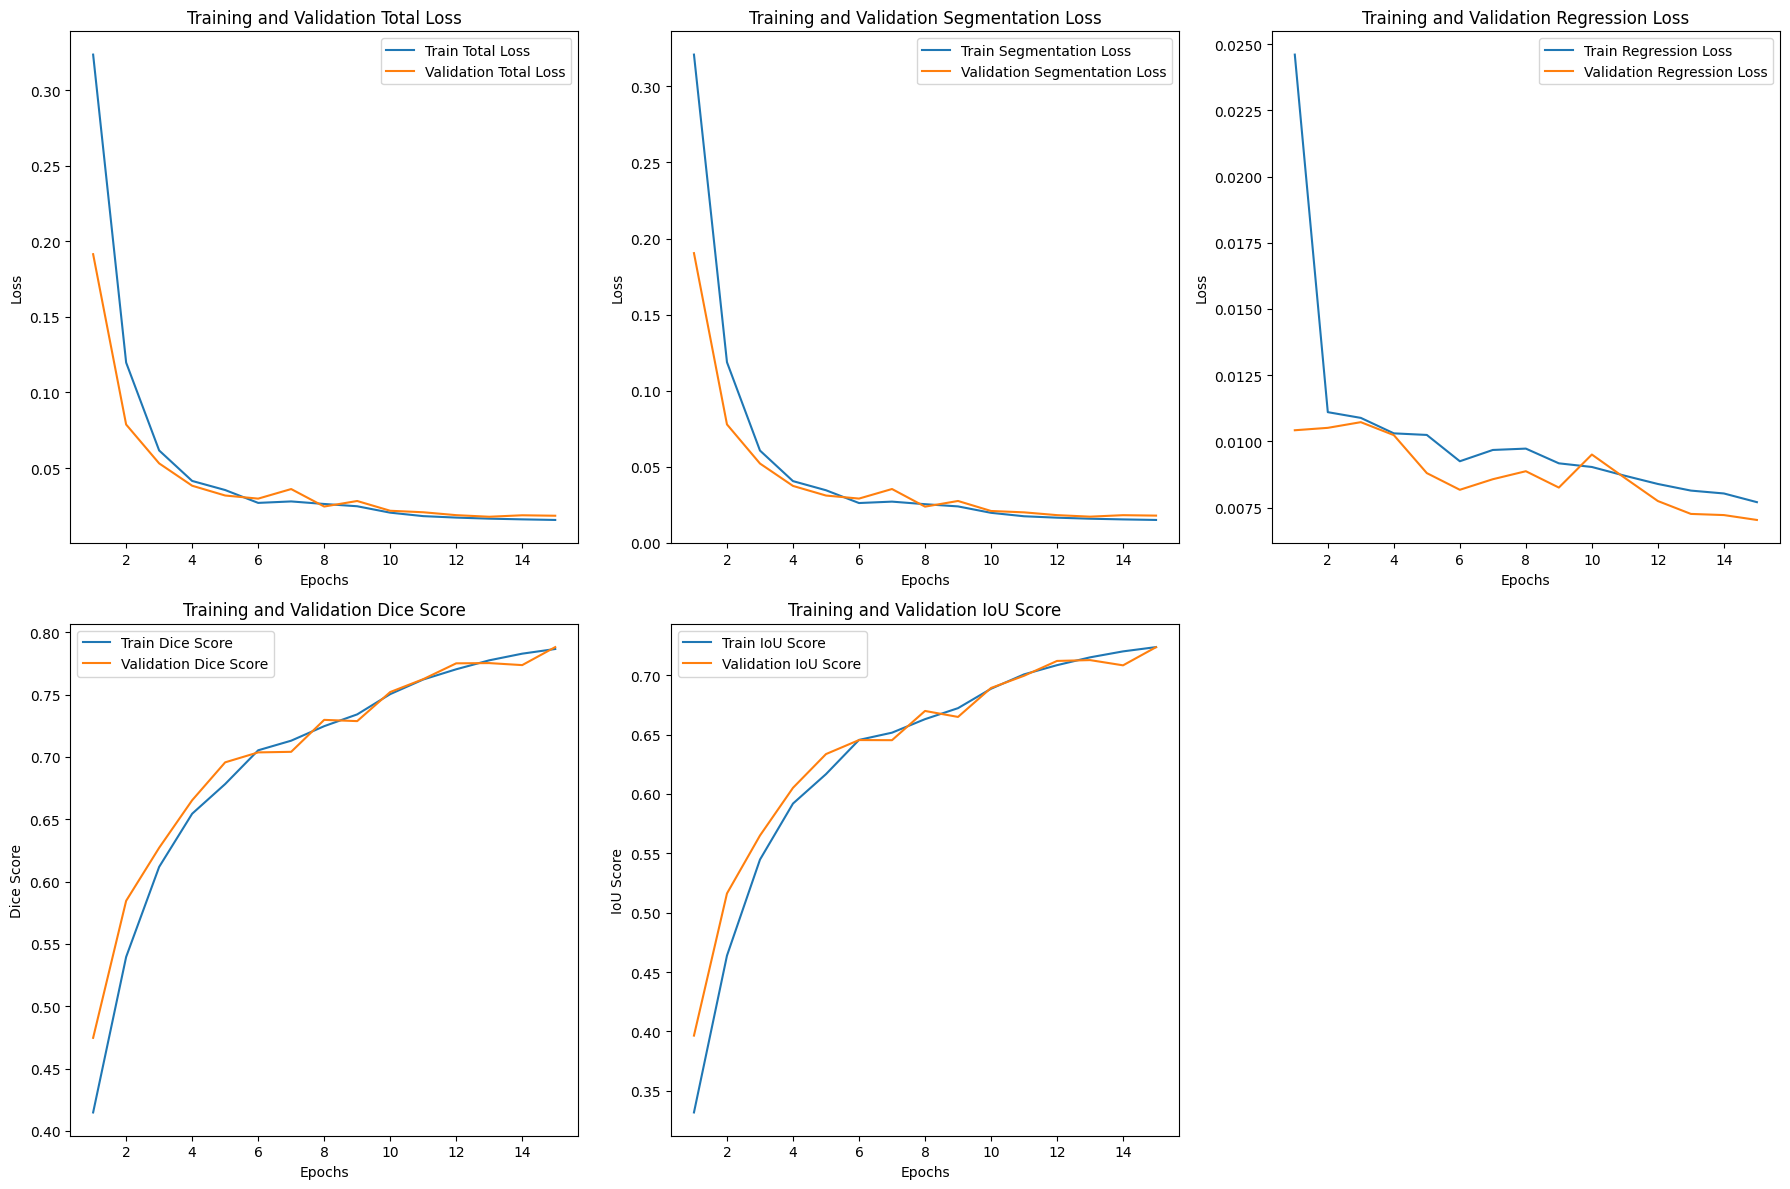

In [8]:
# Cell 8: Plotting Metrics

def plot_metrics(history_dict):
    epochs_range = range(1, len(history_dict['train_loss']) + 1)

    plt.figure(figsize=(18, 12))

    # Plot Total Loss
    plt.subplot(2, 3, 1)
    plt.plot(epochs_range, history_dict['train_loss'], label='Train Total Loss')
    plt.plot(epochs_range, history_dict['val_loss'], label='Validation Total Loss')
    plt.legend(loc='best')
    plt.title('Training and Validation Total Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Plot Segmentation Loss
    plt.subplot(2, 3, 2)
    plt.plot(epochs_range, history_dict['train_seg_loss'], label='Train Segmentation Loss')
    plt.plot(epochs_range, history_dict['val_seg_loss'], label='Validation Segmentation Loss')
    plt.legend(loc='best')
    plt.title('Training and Validation Segmentation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    # Plot Regression Loss if available
    if CONFIG["MULTITASK"] and history_dict.get('train_reg_loss'):
        plt.subplot(2, 3, 3)
        plt.plot(epochs_range, history_dict['train_reg_loss'], label='Train Regression Loss')
        plt.plot(epochs_range, history_dict['val_reg_loss'], label='Validation Regression Loss')
        plt.legend(loc='best')
        plt.title('Training and Validation Regression Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
    
    # Plot Dice Score
    plt.subplot(2, 3, 4)
    plt.plot(epochs_range, history_dict['train_dice'], label='Train Dice Score')
    plt.plot(epochs_range, history_dict['val_dice'], label='Validation Dice Score')
    plt.legend(loc='best')
    plt.title('Training and Validation Dice Score')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Score')
    
    # Plot IoU Score
    plt.subplot(2, 3, 5)
    plt.plot(epochs_range, history_dict['train_iou'], label='Train IoU Score')
    plt.plot(epochs_range, history_dict['val_iou'], label='Validation IoU Score')
    plt.legend(loc='best')
    plt.title('Training and Validation IoU Score')
    plt.xlabel('Epochs')
    plt.ylabel('IoU Score')

    # Plot Accuracy if recorded in history dictionary
    if history_dict.get('train_acc') and history_dict.get('val_acc'):
        plt.subplot(2, 3, 6)
        plt.plot(epochs_range, history_dict['train_acc'], label='Train Accuracy')
        plt.plot(epochs_range, history_dict['val_acc'], label='Validation Accuracy')
        plt.legend(loc='best')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
    else:
        print("Accuracy metrics not recorded in history.")

    plt.tight_layout()
    plt.show()

# Make sure history is populated from training before calling this
if 'history' in globals() and history.get('train_loss', []):
    plot_metrics(history)
else:
    print("No training history to plot. Run the training loop first.")

In [9]:
# Cell 9: Fast Evaluation on Test Set

def evaluate_model(model, loader):
    model.eval()
    total_loss = 0
    total_seg_loss = 0
    total_reg_loss = 0
    total_dice = 0
    total_iou = 0
    total_correct = 0
    total_pixels = 0
    
    num_batches = len(loader)
    if num_batches == 0:
        print("Warning: Test DataLoader is empty. Evaluation cannot proceed.")
        return 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    print("\n📊 Evaluating on Test Set...")
    progress_bar = tqdm(loader, desc="Test Evaluation", leave=False)

    with torch.no_grad():
        for batch_idx, data_batch in enumerate(progress_bar):
            try:
                if CONFIG["MULTITASK"]:
                    images, masks, coords = data_batch
                    images = images.to(CONFIG["DEVICE"], non_blocking=True)
                    masks = masks.to(CONFIG["DEVICE"], non_blocking=True)
                    coords = coords.to(CONFIG["DEVICE"], non_blocking=True)
                    
                    seg_preds, reg_preds = model(images)
                    loss_seg = criterion_segmentation(seg_preds, masks)
                    loss_reg = criterion_regression(reg_preds, coords)
                    loss = loss_seg + 0.1 * loss_reg
                    total_reg_loss += loss_reg.item()
                else:
                    images, masks = data_batch
                    images = images.to(CONFIG["DEVICE"], non_blocking=True)
                    masks = masks.to(CONFIG["DEVICE"], non_blocking=True)
                    
                    seg_preds = model(images)
                    loss_seg = criterion_segmentation(seg_preds, masks)
                    loss = loss_seg

                total_loss += loss.item()
                total_seg_loss += loss_seg.item()
                
                # Compute metrics
                dice = dice_score(seg_preds, masks)
                iou = iou_score(seg_preds, masks)
                total_dice += dice.item()
                total_iou += iou.item()
                
                # Compute pixel accuracy
                pred_labels = torch.argmax(seg_preds, dim=1)
                total_correct += (pred_labels == masks).sum().item()
                total_pixels += masks.numel()

                progress_bar.set_postfix(
                    dice=f"{total_dice/(batch_idx+1):.4f}",
                    iou=f"{total_iou/(batch_idx+1):.4f}"
                )
            except Exception as e:
                print(f"Error in evaluation batch {batch_idx}: {e}")
                continue

    # Calculate final metrics
    avg_loss = total_loss / num_batches
    avg_seg_loss = total_seg_loss / num_batches
    avg_reg_loss = total_reg_loss / num_batches if CONFIG["MULTITASK"] else 0
    avg_dice = total_dice / num_batches
    avg_iou = total_iou / num_batches
    avg_accuracy = total_correct / total_pixels if total_pixels > 0 else 0.0

    print(f"\n🎯 TEST RESULTS:")
    print(f"   Total Loss: {avg_loss:.4f}")
    print(f"   Segmentation Loss: {avg_seg_loss:.4f}")
    if CONFIG["MULTITASK"]:
        print(f"   Regression Loss: {avg_reg_loss:.4f}")
    print(f"   Dice Score: {avg_dice:.4f}")
    print(f"   IoU Score: {avg_iou:.4f}")
    print(f"   Pixel Accuracy: {avg_accuracy:.4f}")
    
    return avg_loss, avg_seg_loss, avg_reg_loss, avg_dice, avg_iou, avg_accuracy

# Load and evaluate the best model
best_model_path = os.path.join(CONFIG["CHECKPOINT_DIR"], "best_model.pth")
if os.path.exists(best_model_path):
    print(f"🔍 Loading best model from: {best_model_path}")
    checkpoint = torch.load(best_model_path, map_location=CONFIG["DEVICE"])
    
    eval_model = TransformerUNet(n_channels_in=1, 
                               n_classes_seg=CONFIG["NUM_CLASSES_SEG"], 
                               n_regression_targets=CONFIG["NUM_REGRESSION_TARGETS"] if CONFIG["MULTITASK"] else 0, 
                               multitask=CONFIG["MULTITASK"]).to(CONFIG["DEVICE"])
    eval_model.load_state_dict(checkpoint['model_state_dict'])
    
    if test_loader and len(test_loader.dataset) > 0:
        if len(test_loader) > 0:
            evaluate_model(eval_model, test_loader)
        else:
            print("Test DataLoader is empty. Skipping evaluation.")
    else:
        print("Test dataset is empty. Skipping evaluation.")
else:
    print("❌ Best model checkpoint not found. Run training first!")

🔍 Loading best model from: checkpoints_fast_unet\best_model.pth

📊 Evaluating on Test Set...

📊 Evaluating on Test Set...



🎯 TEST RESULTS:
   Total Loss: 0.0169
   Segmentation Loss: 0.0161
   Regression Loss: 0.0076
   Dice Score: 0.7928
   IoU Score: 0.7286
   Pixel Accuracy: 0.9964



🖼️ Visualizing 3 predictions...


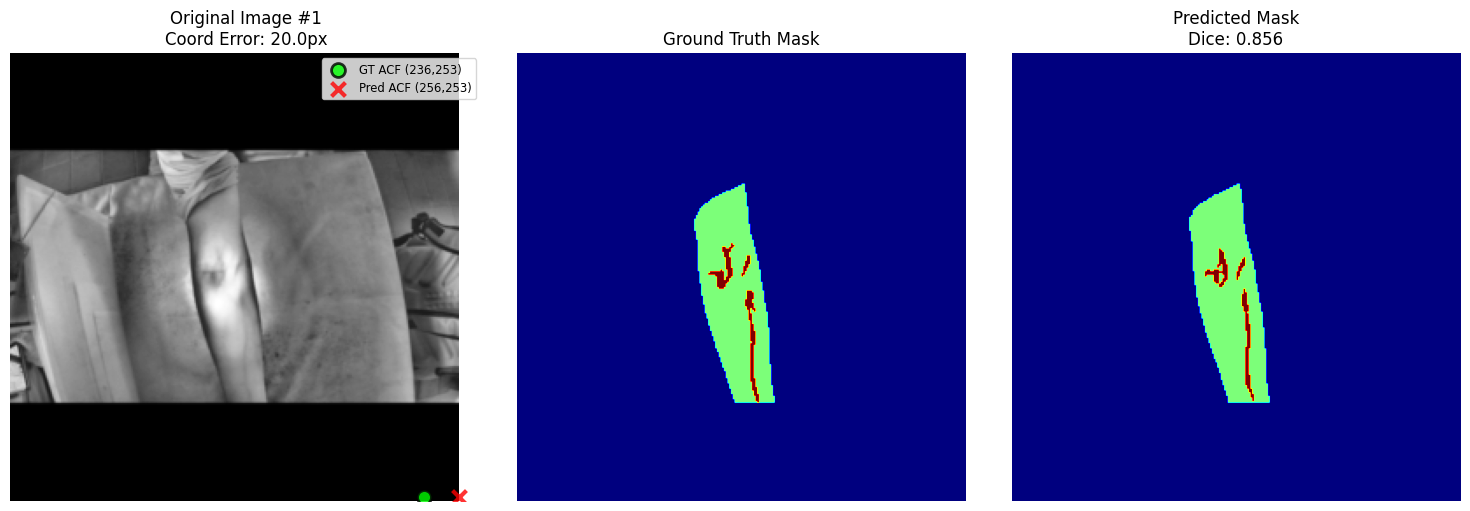

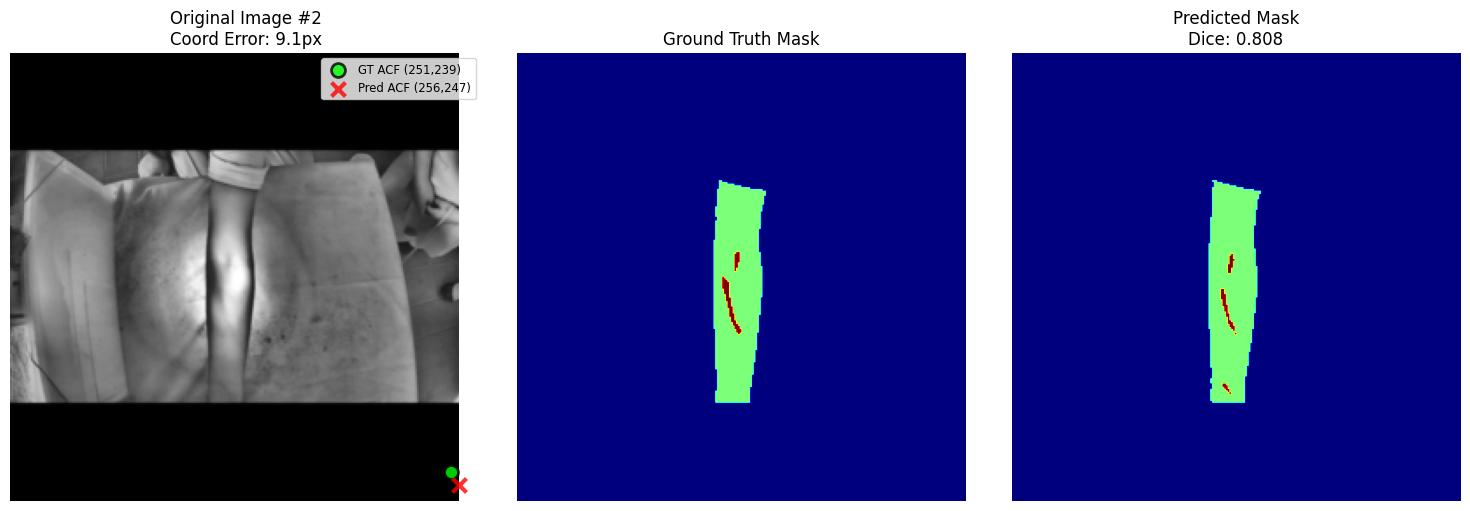

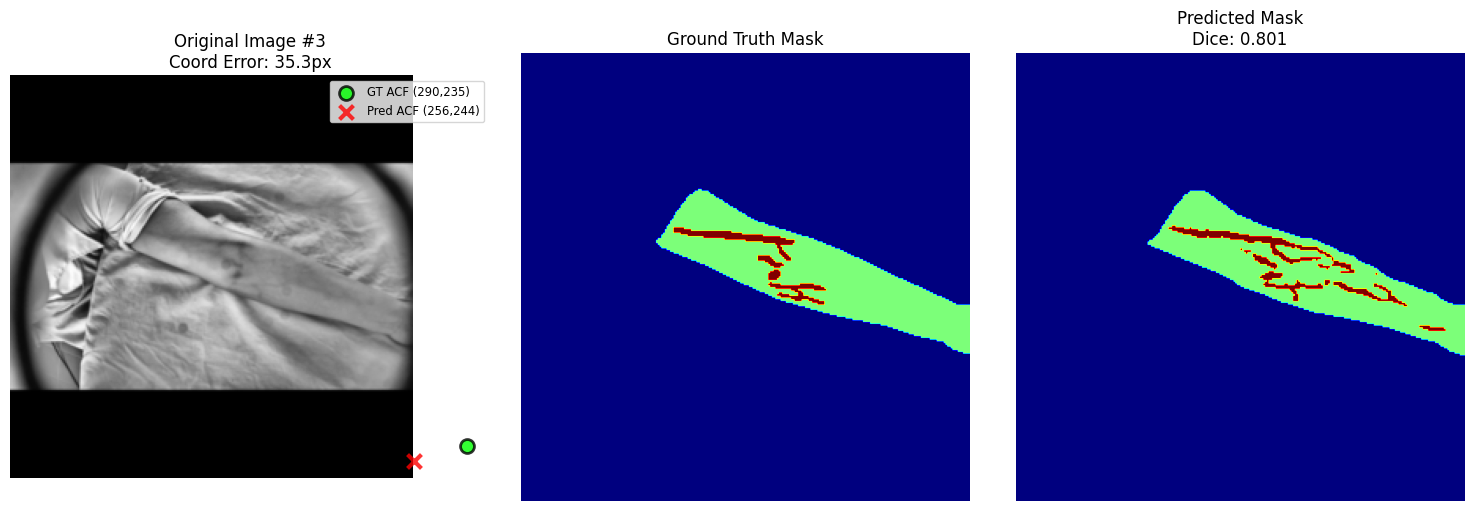

In [10]:
# Cell 10: Fast Prediction & Visualization

def predict_and_visualize(model, dataset, num_samples=3):
    model.eval()
    
    if len(dataset) == 0:
        print("Dataset is empty, cannot visualize predictions.")
        return

    num_samples = min(num_samples, len(dataset))
    if num_samples == 0:
        print("No samples to visualize.")
        return

    print(f"\n🖼️ Visualizing {num_samples} predictions...")
    
    # Get random samples
    sample_indices = random.sample(range(len(dataset)), num_samples)
    
    with torch.no_grad():
        for idx, i in enumerate(sample_indices):
            if CONFIG["MULTITASK"]:
                image, gt_mask, gt_coords = dataset[i]
            else:
                image, gt_mask = dataset[i]
                gt_coords = None

            # Prepare image for model
            image_batch = image.unsqueeze(0).to(CONFIG["DEVICE"])

            if CONFIG["MULTITASK"]:
                pred_seg_logits, pred_coords_norm = model(image_batch)
            else:
                pred_seg_logits = model(image_batch)
                pred_coords_norm = None

            # Process predictions
            pred_mask_probs = torch.softmax(pred_seg_logits, dim=1)
            pred_mask = torch.argmax(pred_mask_probs, dim=1).squeeze(0).cpu().numpy()

            # Denormalize image for display
            img_display = (image.cpu().squeeze().numpy() * 0.229) + 0.485
            img_display = np.clip(img_display, 0, 1)
            gt_mask_display = gt_mask.cpu().squeeze().numpy()

            plt.figure(figsize=(15, 5))
            
            # Original Image with coordinates
            plt.subplot(1, 3, 1)
            plt.imshow(img_display, cmap='gray')
            plt.title(f"Original Image #{idx+1}")
            
            if CONFIG["MULTITASK"] and gt_coords is not None:
                img_h, img_w = CONFIG["IMAGE_SIZE"]
                # Ground truth coordinates
                gt_x = gt_coords[0].item() * img_w
                gt_y = gt_coords[1].item() * img_h
                plt.scatter([gt_x], [gt_y], c='lime', marker='o', s=100, 
                           label=f'GT ACF ({gt_x:.0f},{gt_y:.0f})', 
                           alpha=0.8, edgecolors='black', linewidth=2)
                
                # Predicted coordinates
                if pred_coords_norm is not None:
                    pred_coords_cpu = pred_coords_norm.squeeze(0).cpu()
                    pred_x = pred_coords_cpu[0].item() * img_w
                    pred_y = pred_coords_cpu[1].item() * img_h
                    plt.scatter([pred_x], [pred_y], c='red', marker='x', s=100, 
                               label=f'Pred ACF ({pred_x:.0f},{pred_y:.0f})', 
                               alpha=0.8, linewidth=3)
                    
                    # Calculate distance error
                    distance_error = np.sqrt((gt_x - pred_x)**2 + (gt_y - pred_y)**2)
                    plt.title(f"Original Image #{idx+1}\nCoord Error: {distance_error:.1f}px")
                
                plt.legend(fontsize='small', loc='upper right')
            plt.axis('off')

            # Ground Truth Mask
            plt.subplot(1, 3, 2)
            plt.imshow(gt_mask_display, cmap='jet', vmin=0, vmax=CONFIG["NUM_CLASSES_SEG"]-1)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Predicted Mask
            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask, cmap='jet', vmin=0, vmax=CONFIG["NUM_CLASSES_SEG"]-1)
            
            # Calculate Dice score for this sample
            gt_mask_tensor = gt_mask.unsqueeze(0).to(CONFIG["DEVICE"])
            sample_dice = dice_score(pred_seg_logits, gt_mask_tensor).item()
            plt.title(f"Predicted Mask\nDice: {sample_dice:.3f}")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()

# Visualize predictions
if 'eval_model' in locals() and isinstance(eval_model, nn.Module):
    predict_and_visualize(eval_model, test_dataset, num_samples=3)
elif os.path.exists(best_model_path):
    print(f"🔍 Loading best model for visualization...")
    checkpoint = torch.load(best_model_path, map_location=CONFIG["DEVICE"])
    vis_model = TransformerUNet(n_channels_in=1, 
                              n_classes_seg=CONFIG["NUM_CLASSES_SEG"], 
                              n_regression_targets=CONFIG["NUM_REGRESSION_TARGETS"] if CONFIG["MULTITASK"] else 0, 
                              multitask=CONFIG["MULTITASK"]).to(CONFIG["DEVICE"])
    vis_model.load_state_dict(checkpoint['model_state_dict'])
    predict_and_visualize(vis_model, test_dataset, num_samples=3)
else:
    print("❌ No trained model available for visualization. Please train a model first!")

